# Optimal UTXO size for difficulty and static reward

Quickly find the optimal Peercoin UTXO size for a given difficulty and static reward. Parameters can be adjusted for the displayed chart.

This uses daily probabilities as an approximation for per-second probabilities. It also assumes minting occurs continuously.

Determines the probability distribution for mints across multiple days and then finds a geometric average reward weighted by these probabilities.

Produced by MattLM with credit to Nagalim for ideas and alternative solutions.

Tips are welcome: PTuwboaoow7XF7Vrr68oremimo9wgrvxQ6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6.0, 5.0]

## Parameters

In [2]:
MAX_DAYS = 365*4
MIN_PROB_DAYS = 30
RAMP_UP = 60
RELATIVE_REWARD = 0.03
BLOCK_INTERVAL_SECS = 60*10

In [3]:
# Supply in coins. Whilst the total supply can be used, some coins may be considerated irredeemable.
SUPPLY = 28327842
DIFF = 21.2025
STATIC_REWARD = 1.35
EXAMPLE_SIZE = 100

# Recommended to keep False.
# This compounds the return of a single-output.
# This under-estimates returns for a wallet with many small utxos as
# the slow-compounding effects are removed when there are many outputs.
GEOMETRIC=False

## Helpful constants

In [4]:
SECDAY=60*60*24
DAYYEAR=(365*33+8)/33
# Offset days by 0.5 to assume mint occurs somewhere in middle of day
DAYS = [MIN_PROB_DAYS+x+0.5 for x in range(MAX_DAYS)]
NO_MINT_DAY = MAX_DAYS+MIN_PROB_DAYS
DAYS_WITH_NO_MINT = DAYS + [NO_MINT_DAY]

## Calculate daily probability distribution

Includes the rampup

In [5]:
# Max weight is the ramp up or assume a constant half day if no ramp up
maxDayWeight = RAMP_UP if RAMP_UP > 0 else 0.5
# Offset by 0.5 to assume middle of day
dayWeights = np.clip(np.arange(MAX_DAYS) + 0.5, 0, maxDayWeight)
# 60/maxDayWeight normalises so that the end probability is always the same
probSecs = dayWeights * 60/maxDayWeight / 2**32

In [6]:
def generateDailyProbs(outValue, diff):
    
    adj = outValue / diff

    # Independent probabilities
    failDayProbs = (1 - probSecs*adj)**SECDAY
    mintDayProbs = 1 - failDayProbs

    # Actual probability of mint on day assuming no mints before
    cumFail = failDayProbs.cumprod()
    # Prob of fail up-to now
    cumPrevFail = np.insert(cumFail, 0, 1)[:MAX_DAYS]
    # Prob of fail up-to now and success now gives chance of mint on this day
    # Add probabilty of final day to represent no successful mints
    return np.append(cumPrevFail*mintDayProbs, cumFail[-1])
        

In [7]:
dayProbs = generateDailyProbs(EXAMPLE_SIZE, DIFF)

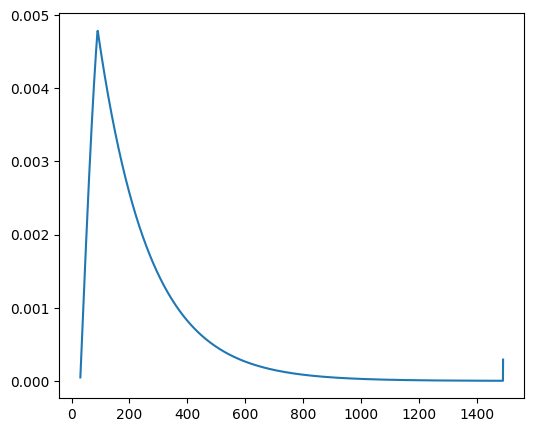

In [8]:
plt.plot(DAYS_WITH_NO_MINT, dayProbs)
plt.show()

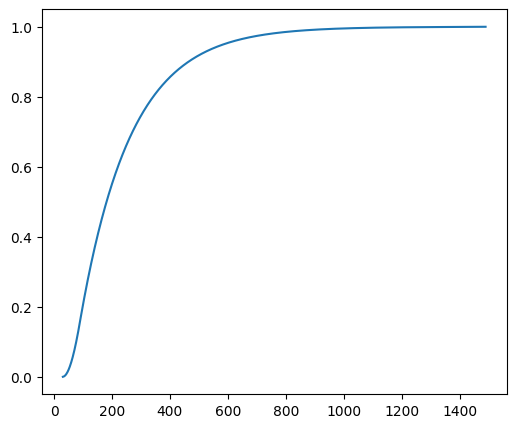

In [9]:
plt.plot(DAYS_WITH_NO_MINT, dayProbs.cumsum())
plt.show()

In [10]:
# Should add up to 1
dayProbs.sum()

1.0000000000000002

## Calculate Geometric average of rewards weighted by probabilities

In [11]:
def dailyRewards(outValue, staticReward):
    mintRewards = np.fromiter((outValue*RELATIVE_REWARD*min(365, x)/DAYYEAR + staticReward for x in DAYS), dtype=float)
    includingFailed = np.append(mintRewards, 0)
    return includingFailed

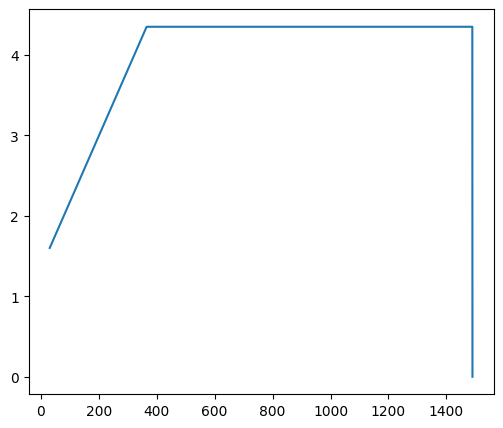

In [12]:
rewards = dailyRewards(EXAMPLE_SIZE, STATIC_REWARD)
plt.plot(DAYS_WITH_NO_MINT, rewards)
plt.show()

In [13]:
def averageReward(outValue, diff, staticReward, geometric=GEOMETRIC):
    probs = generateDailyProbs(outValue, diff)
    rewards = dailyRewards(outValue, staticReward)
    weightedTime = (DAYS_WITH_NO_MINT*probs).sum()

    if geometric:
        returns = 1+rewards/outValue
        weightedReturn = (returns**probs).prod()
        return (weightedReturn**(DAYYEAR/weightedTime) - 1) * 100

    # Arithmetic
    returns = rewards/outValue
    weightedReturn = (returns*probs).sum()
    return (weightedReturn*(DAYYEAR/weightedTime)) * 100

In [14]:
averageReward(EXAMPLE_SIZE, DIFF, STATIC_REWARD)

4.703351999236596

## Plot UTXO sizes

In [15]:
sizes = [10**(x/125) for x in range(501)]

In [16]:
rewardForSizes = np.fromiter((averageReward(x, DIFF, STATIC_REWARD) for x in sizes), dtype=float)

In [17]:
def addFigText(optimal):
    plt.figtext(0.5, -0.03, f"Additional parameters: percentage reward={RELATIVE_REWARD*100}%, min days={MIN_PROB_DAYS}, ramp days={RAMP_UP}, max days={MAX_DAYS}, geometric={GEOMETRIC}", ha="center", fontsize=10)
    plt.figtext(0.5, -0.08, f"Optimal UTXO Size: {optimal:.6f} PPC", ha="center", fontsize=10)

In [18]:
def plotResults(results, yLabel, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sizes, results)
    ax.set_xlabel("UTXO Size")
    ax.set_ylabel(yLabel)
    ax.set_title(title)
    addFigText(sizes[results.argmax()])
    plt.xscale("log")
    plt.grid(which="both")
    plt.show()

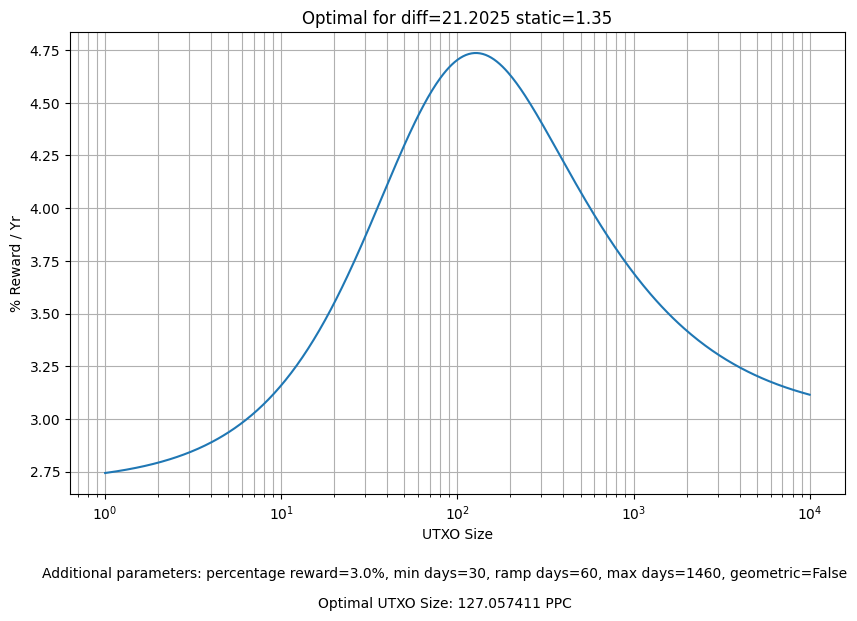

In [19]:
plotResults(rewardForSizes, "% Reward / Yr", f"Optimal for diff={DIFF} static={STATIC_REWARD}")

## Number of Mints

In [20]:
def averageMints(outValue, diff):
    probs = generateDailyProbs(outValue, diff)
    probFail = probs[-1]
    weightedTime = (DAYS_WITH_NO_MINT*probs).sum()
    return (1-probFail)/weightedTime/outValue*365

In [21]:
mintsForSizes = np.fromiter((averageMints(x, DIFF) for x in sizes), dtype=float)

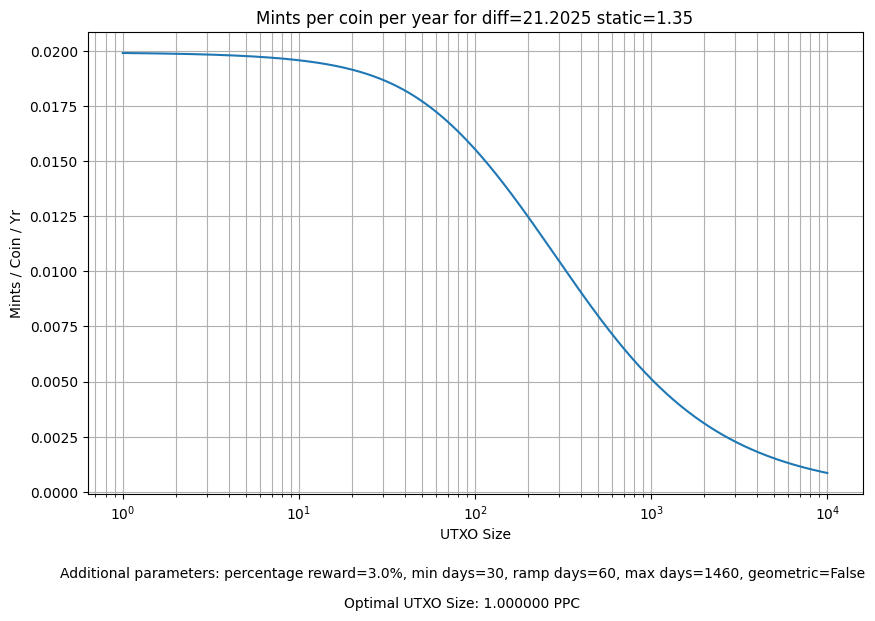

In [22]:
plotResults(mintsForSizes, "Mints / Coin / Yr", f"Mints per coin per year for diff={DIFF} static={STATIC_REWARD}")

## Security

The percentage of supply at full optimisation required to meet the block interval at current difficulty.

In [23]:
mintsPerCoinInterval = averageMints(0.01, DIFF) * BLOCK_INTERVAL_SECS / 365 / 24 / 60 / 60
expectedMintsAtFullSupply = mintsPerCoinInterval * SUPPLY
securityLevel = 1/expectedMintsAtFullSupply
print(f"Security Level = {securityLevel}")

Security Level = 0.09304452857122905


In [24]:
# Max difficulty at current supply and interval
DIFF / securityLevel

227.87476411112877

In [25]:
SUPPLY / (DIFF / securityLevel)

124313.20383588078

In [26]:
supplyToMaxDiffConstant = 124313
SUPPLY / supplyToMaxDiffConstant

227.8751377571131

In [27]:
# Simplified calculation given ramp-up of 60
DIFF / SUPPLY * supplyToMaxDiffConstant

0.09304437600647449

In [28]:
# Calculation including ramp up linear estimated adjustment.
# The adjustment is correct for ramp-ups of 0 and 60 but over-estimates between 0 and 60 and under-estimates over 60.
# The difference is security is minimal for the ramp-up
RAMP_SEC_ADJ = 0.00034811341217566*(RAMP_UP-60)+1
DIFF / SUPPLY * 124353.6277 * RAMP_SEC_ADJ

0.09307478456386653

In [29]:
# Nagalim's Formula which assumes infinite mint time-horizon and that 0.01ppc outputs have negligible impact of probabilities below maximum.
# Using this as actual security calculation for purposes of regressions below.
# Replaced maxDayWeight with 60 as the maximum probability should be normalised at x60
supplyToMaxDiffDivisor = 2**32 / BLOCK_INTERVAL_SECS / 60
def getSecurityLevel(diff, supply):
    return diff * supplyToMaxDiffDivisor / supply
getSecurityLevel(DIFF, SUPPLY)

0.08929578117434196

In [30]:
def getDiffFromSecurity(securityLevel, supply):
    return securityLevel * supply / supplyToMaxDiffDivisor
getDiffFromSecurity(securityLevel, SUPPLY)

22.092607188012785

## Combined Chart

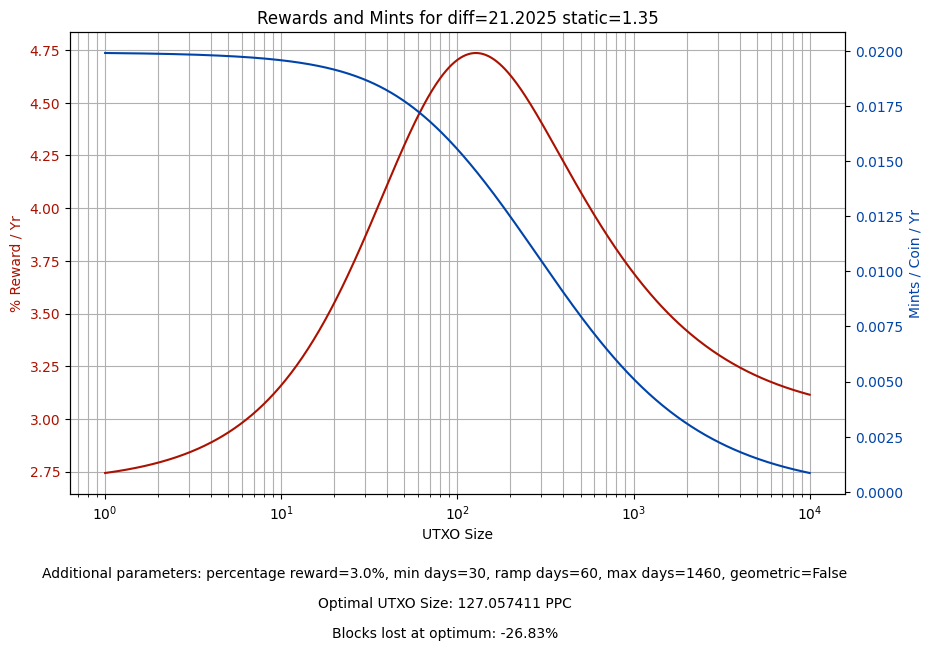

In [31]:
fig, rewardAx = plt.subplots(figsize=(10, 6))
rewardAx.set_title(f"Rewards and Mints for diff={DIFF} static={STATIC_REWARD}")
rewardAx.set_xlabel("UTXO Size")

colour = "#A10"
rewardAx.plot(sizes, rewardForSizes, color=colour)
rewardAx.tick_params(axis ='y', labelcolor=colour) 
rewardAx.set_ylabel("% Reward / Yr", color=colour)

mintsAx = rewardAx.twinx()
colour = "#04A"
mintsAx.plot(sizes, mintsForSizes, color=colour)
mintsAx.tick_params(axis ='y', labelcolor=colour) 
mintsAx.set_ylabel("Mints / Coin / Yr", color=colour)

addFigText(sizes[rewardForSizes.argmax()])

blockLoss = (1 - mintsForSizes[rewardForSizes.argmax()] / mintsForSizes.max())*100
plt.figtext(0.5, -0.13, f"Blocks lost at optimum: -{blockLoss:.2f}%", ha="center", fontsize=10)

plt.xscale("log")
rewardAx.grid(which="both")
plt.show()

## Optimal UTXO Size

In [32]:
# UTXO Size
maxI = rewardForSizes.argmax()
sizes[maxI]

127.05741052085419

In [33]:
# Reward
maxReward = rewardForSizes.max()
maxReward

4.736007326560475

In [34]:
def findWithinTolerance(it, tolerance):
    for i in it:
        if (maxReward - rewardForSizes[i] > tolerance):
            return sizes[i+1]

In [35]:
# -10bps Left
findWithinTolerance(reversed(range(0, maxI)), 0.1)

84.72274141405963

In [36]:
# -10bps Right
findWithinTolerance(range(maxI, len(sizes)), 0.1)

201.37242498623874

In [37]:
# -20bps Left
findWithinTolerance(reversed(range(0, maxI)), 0.2)

70.46930689671471

In [38]:
# -20bps Right
findWithinTolerance(range(maxI, len(sizes)), 0.2)

246.60393372343387

## Peak-finder

In [39]:
def findPeak(diff, staticReward, iterations):
    
    size = 10
    reward = averageReward(size, diff, staticReward)
    movement = 2

    for i in range(iterations):
        
        nextSize = size*movement
        nextReward = averageReward(nextSize, diff, staticReward)

        if nextReward > reward:
            size = nextSize
            reward = nextReward
        else:
            # Reverse movement and go back at slightly less than half relative pace
            movement = 1 / movement**0.45

    return (size, reward)

In [40]:
findPeak(DIFF, STATIC_REWARD, iterations=20)

(127.28753773110417, 4.736009035957543)

In [41]:
maxDiff = DIFF / securityLevel

In [42]:
# Very small difference after 20 iterations
findPeak(maxDiff, STATIC_REWARD, iterations=1000)[1] - findPeak(maxDiff, STATIC_REWARD, iterations=20)[1]

2.985627123308632e-08

In [43]:
# 15 iterations likely OK
findPeak(maxDiff, STATIC_REWARD, iterations=1000)[1] - findPeak(maxDiff, STATIC_REWARD, iterations=15)[1]

6.250386914707917e-07

In [44]:
# 15 iterations OK, even if difficulty were to be extreme
findPeak(1000, STATIC_REWARD, iterations=15)

(19226.427469852104, 3.024545085101301)

In [45]:
findPeak(1000, STATIC_REWARD, iterations=1000)[1] - findPeak(1000, STATIC_REWARD, iterations=15)[1]

0.0002497707184185849

In [46]:
# 15 iterations OK, likewise with extremely small (unreasonably small) utxo optimum.
findPeak(1, STATIC_REWARD, iterations=15)

(0.12691443693066182, 57.00318970477253)

In [47]:
findPeak(1, STATIC_REWARD, iterations=1000)[1] - findPeak(1, STATIC_REWARD, iterations=15)[1]

0.11400906531672206

## Peak across difficulties

In [48]:
diffs = list(range(1, 300))
optimumForDiffStatic1 = np.fromiter((findPeak(x, 1, iterations=30)[0] for x in diffs), dtype=float)
optimumForDiffStatic2 = np.fromiter((findPeak(x, 2, iterations=30)[0] for x in diffs), dtype=float)
optimumForDiffStatic3 = np.fromiter((findPeak(x, 3, iterations=30)[0] for x in diffs), dtype=float)

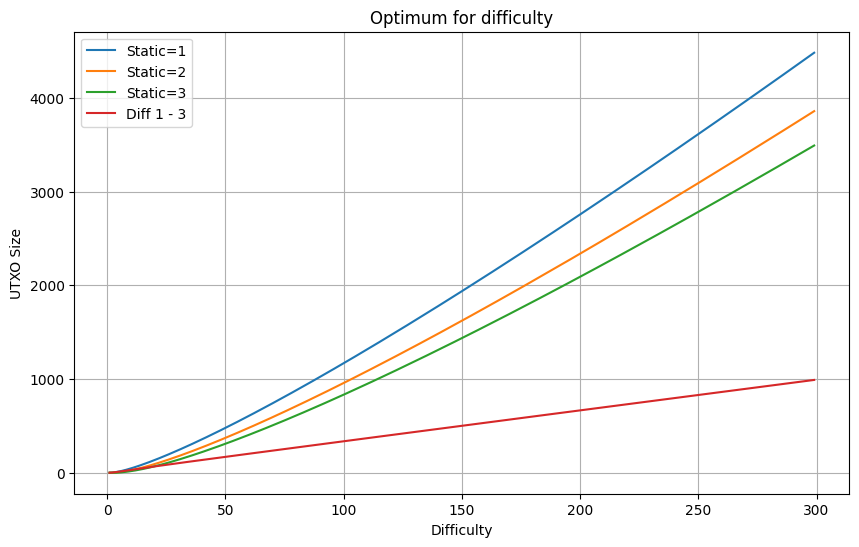

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))

h1, = ax.plot(diffs, optimumForDiffStatic1, label="Static=1")
h2, = ax.plot(diffs, optimumForDiffStatic2, label="Static=2")
h3, = ax.plot(diffs, optimumForDiffStatic3, label="Static=3")
h4, = ax.plot(diffs, optimumForDiffStatic1-optimumForDiffStatic3, label="Diff 1 - 3")
ax.legend(handles=[h1, h2, h3, h4])

ax.set_xlabel("Difficulty")
ax.set_ylabel("UTXO Size")
ax.set_title("Optimum for difficulty")
plt.grid(which="both")
plt.show()

## Regression for difficulty at constant static reward

In [50]:
import statsmodels.api as sm
import pandas as pd

Try static=1 and polynomial fit for diff

In [51]:
diffs = np.array(diffs)
exog = pd.DataFrame({
    "const": 1,
    "diff": diffs,
    "diff^(1/2)": diffs**(1/2),
    "diff^(1/3)": diffs**(1/3),
    "diff^(1/4)": diffs**(1/4),
    "diff^(1/5)": diffs**(1/5),
    "diff^(1/6)": diffs**(1/6),
    "diff^(1/7)": diffs**(1/7),
    "diff^(1/8)": diffs**(1/8),
})

In [52]:
model = sm.OLS(optimumForDiffStatic1, exog).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.321e+10
Date:                Mon, 28 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:40:12   Log-Likelihood:                 625.61
No. Observations:                 299   AIC:                            -1233.
Df Residuals:                     290   BIC:                            -1200.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.155e+06   2.56e+05      8.424      0.000    1.65e+06    2.66e+06
diff          52.9476      1.822     29.062      0.000      49.362      56.533
diff^(1/2) -9.493e+04   9162.107    -10.361      0.000   -1.13e+05   -7.69e+04
diff^(1/3)  7.713e+06   8.13e+05      9.491      0.000    6.11e+06    9.31e+06
diff^(1/4) -1.218e+08   1.33e+07     -9.175      0.000   -1.48e+08   -9.57e+07
diff^(1/5)   6.69e+08   7.43e+07      9.006      0.000    5.23e+08    8.15e+08
diff^(1/6)  -1.58e+09   1.77e+08     -8.901      0.000   -1.93e+09   -1.23e+09
diff^(1/7)  1.656e+09   1.88e+08      8.828      0.000    1.29e+09    2.03e+09
diff^(1/8) -6.336e+08   7.22e+07     -8.775      0.000   -7.76e+08   -4.91e+08
==============================================================================
Omnibus:                       57.830   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              844.763
Skew:                           0.072   Prob(JB):                    3.65e-184
Kurtosis:                      11.233   Cond. No.                     2.76e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.18e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

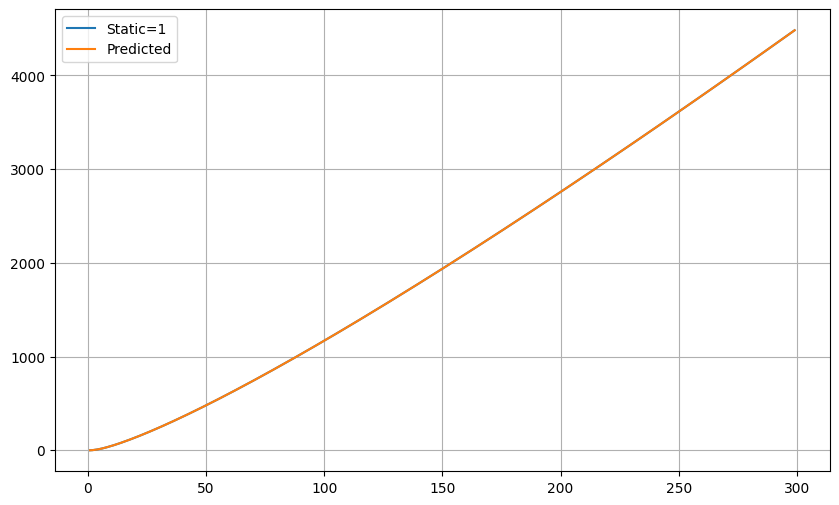

In [53]:
ypred = model.predict(exog)
fig, ax = plt.subplots(figsize=(10, 6))
h1, = ax.plot(diffs, optimumForDiffStatic1, label="Static=1")
h2, = ax.plot(diffs, ypred, label="Predicted")
ax.legend(handles=[h1, h2])
plt.grid(which="both")
plt.show()

## Diff/Static Regression Analysis

Predict optimal UTXO from diff and static.

The multifactor regression should be good enough upto around diff=150 and static=7, but is fitted up to diff=100 and static=5

Using root terms doesn't work well here.

Try multifactorial regression with diff and static reward

In [54]:
# Generate samples
def getDiffStaticData(staticStart, staticEnd, staticStep, diffStart, diffEnd, diffStep):
    statics = pd.DataFrame(np.arange(staticStart, staticEnd, staticStep), columns=["static"])
    return statics.merge(pd.DataFrame(np.arange(diffStart, diffEnd, diffStep), columns=["diff"]), how="cross")
data = getDiffStaticData(0.8, 5.1, 0.2, 5, 100.1, 1)

In [55]:
endog = data.apply(lambda row: findPeak(row["diff"], row["static"], iterations=50)[0], axis=1)

In [56]:
def getExog(data):
    return pd.DataFrame({
        
        "const": 1,
        
        "diff": data["diff"],
        "diff^2": data["diff"]**2,
        "diff^3": data["diff"]**3,
        "diff^4": data["diff"]**4,
        "diff^5": data["diff"]**5,
        "diff^6": data["diff"]**6,
        "diff^(1/2)": data["diff"]**0.5,
        
        "diff*static": data["diff"]*data["static"],
        "diff*static^2": data["diff"]*data["static"]**2,
        "diff*static^3": data["diff"]*data["static"]**3,
        "diff*static^4": data["diff"]*data["static"]**4,
        "diff*static^(1/2)": data["diff"]*data["static"]**0.5,
        
        "diff^2*static": data["diff"]**2*data["static"],
        "diff^2*static^2": data["diff"]**2*data["static"]**2,
        "diff^2*static^3": data["diff"]**2*data["static"]**3,  
        
        "diff^3*static": data["diff"]**3*data["static"],
        "diff^3*static^2": data["diff"]**3*data["static"]**2,
        "diff^3*static^3": data["diff"]**3*data["static"]**3,
        
        "diff^4*static": data["diff"]**4*data["static"],
        "diff^4*static^2": data["diff"]**4*data["static"]**2,
        "diff^4*static^3": data["diff"]**4*data["static"]**3,

        "diff^(1/2)*static": data["diff"]**0.5*data["static"],
        "diff^(1/2)*static^2": data["diff"]**0.5*data["static"]**2,
        
    })
exog = getExog(data)

In [57]:
model = sm.OLS(endog, exog).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.188e+08
Date:                Mon, 28 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:41:10   Log-Likelihood:                 1519.7
No. Observations:                2112   AIC:                            -2991.
Df Residuals:                    2088   BIC:                            -2856.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.6438      0.628     21.722      0.000      12.412      14.876
diff                   21.0765      0.148    142.541      0.000      20.787      21.367
diff^2                  0.0787      0.004     20.193      0.000       0.071       0.086
diff^3                 -0.0013   8.49e-05    -15.593      0.000      -0.001      -0.001
diff^4               1.699e-05   1.11e-06     15.319      0.000    1.48e-05    1.92e-05
diff^5              -1.093e-07   7.72e-09    -14.165      0.000   -1.24e-07   -9.42e-08
diff^6               2.573e-10   2.18e-11     11.785      0.000    2.14e-10       3e-10
diff^(1/2)            -26.3577      0.562    -46.877      0.000     -27.460     -25.255
diff*static             3.7704      0.045     83.549      0.000       3.682       3.859
diff*static^2          -0.3679      0.010    -36.725      0.000      -0.388      -0.348
diff*static^3           0.0539      0.001     39.686      0.000       0.051       0.057
diff*static^4          -0.0033   8.15e-05    -40.946      0.000      -0.003      -0.003
diff*static^(1/2)     -15.2411      0.050   -307.704      0.000     -15.338     -15.144
diff^2*static           0.0457      0.001     52.738      0.000       0.044       0.047
diff^2*static^2        -0.0089      0.000    -32.237      0.000      -0.009      -0.008
diff^2*static^3         0.0006   2.99e-05     19.467      0.000       0.001       0.001
diff^3*static          -0.0005   1.32e-05    -41.387      0.000      -0.001      -0.001
diff^3*static^2         0.0001   4.52e-06     27.181      0.000       0.000       0.000
diff^3*static^3     -8.852e-06   5.02e-07    -17.625      0.000   -9.84e-06   -7.87e-06
diff^4*static        2.316e-06   6.66e-08     34.755      0.000    2.19e-06    2.45e-06
diff^4*static^2     -5.635e-07   2.36e-08    -23.906      0.000    -6.1e-07   -5.17e-07
diff^4*static^3      4.281e-08   2.64e-09     16.206      0.000    3.76e-08     4.8e-08
diff^(1/2)*static       4.3378      0.064     67.479      0.000       4.212       4.464
diff^(1/2)*static^2    -0.2382      0.011    -21.897      0.000      -0.260      -0.217
==============================================================================
Omnibus:                      365.992   Durbin-Watson:                   0.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2235.044
Skew:                          -0.668   Prob(JB):                         0.00
Kurtosis:                       7.859   Cond. No.                     9.66e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.66e+13. This might indicate that there are
strong multicollinearity or other numerical problems.

In [58]:
for i, x in model.params.items():
    print(f"{i:>20}: {x:.14f}")

               const: 13.64383329277205
                diff: 21.07654293231289
              diff^2: 0.07873508098100
              diff^3: -0.00132349407738
              diff^4: 0.00001698809252
              diff^5: -0.00000010933083
              diff^6: 0.00000000025728
          diff^(1/2): -26.35770742740095
         diff*static: 3.77037647161961
       diff*static^2: -0.36789595942307
       diff*static^3: 0.05391491053306
       diff*static^4: -0.00333837386104
   diff*static^(1/2): -15.24108909056980
       diff^2*static: 0.04573577467086
     diff^2*static^2: -0.00891140498368
     diff^2*static^3: 0.00058199936124
       diff^3*static: -0.00054548125505
     diff^3*static^2: 0.00012295059481
     diff^3*static^3: -0.00000885186092
       diff^4*static: 0.00000231606320
     diff^4*static^2: -0.00000056348913
     diff^4*static^3: 0.00000004280696
   diff^(1/2)*static: 4.33779150048136
 diff^(1/2)*static^2: -0.23819948344569


In [59]:
showDiffOutOfSample = True
showStaticOutOfSample = True

outOfSampleData = getDiffStaticData(
    0.6 if showStaticOutOfSample else 0.8, 7.1 if showStaticOutOfSample else 5.1, 0.5,
    2 if showDiffOutOfSample else 5, 150.1 if showDiffOutOfSample else 100.1, 4
)
outOfSampleExog = getExog(outOfSampleData)
# Use 30 iterations to show out of sample for speed and simplicity
outOfSampleEndog = outOfSampleData.apply(lambda row: findPeak(row["diff"], row["static"], iterations=30)[0], axis=1)

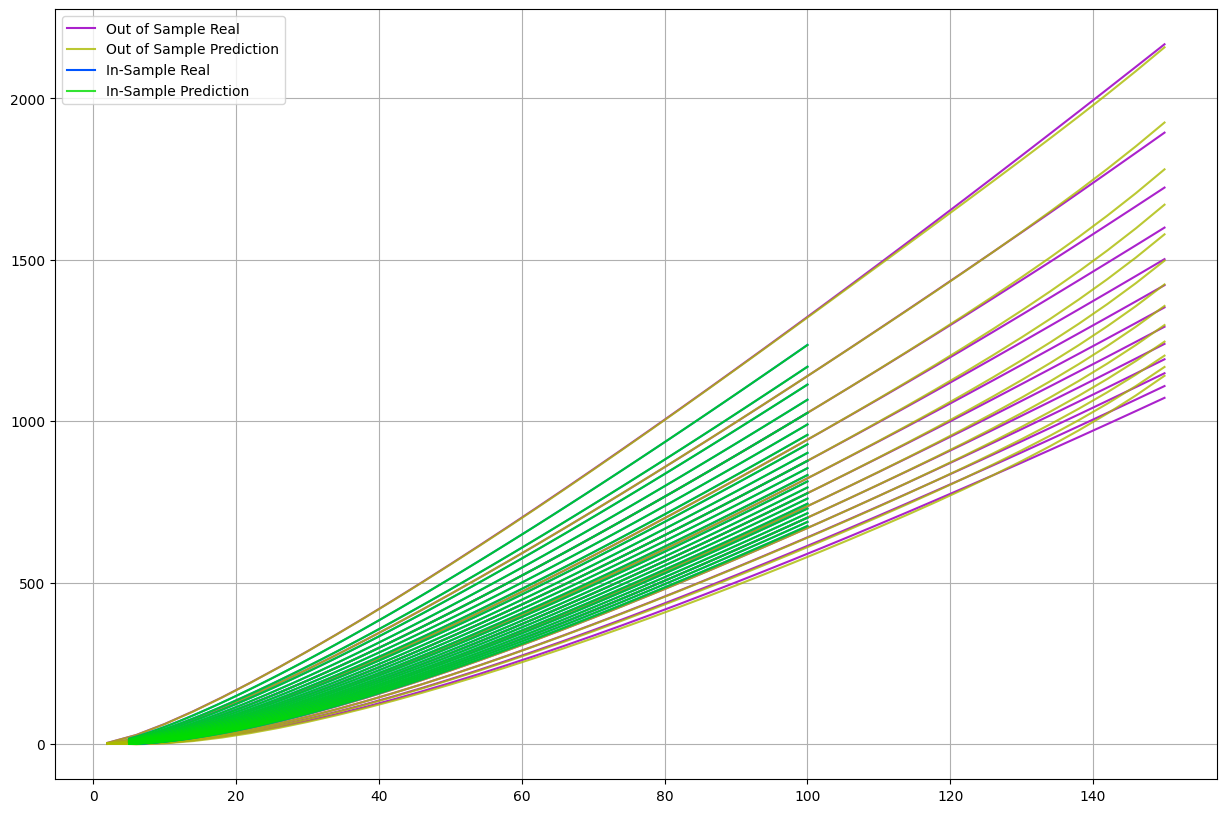

In [60]:
fig, ax = plt.subplots(figsize=(15, 10))

def drawLines(predicted, data, endog, exog, color, label, step=1):
    
    statics = data["static"].drop_duplicates(ignore_index=True)
    
    for i in range(0, len(statics), step):
    
        static = statics[i]
        locations = data["static"] == static
        forStaticExog = exog[locations]
        forStaticEndog = endog[locations]

        handle = ax.plot(forStaticExog["diff"], model.predict(forStaticExog) if predicted else forStaticEndog, color=color, label=label)[0]

    return handle

# Out of sample first so it shows underneath
hOutReal = drawLines(False, outOfSampleData, outOfSampleEndog, outOfSampleExog, "#a2c", "Out of Sample Real")
hOutPreciction = drawLines(True, outOfSampleData, outOfSampleEndog, outOfSampleExog, "#ab0c", "Out of Sample Prediction")

# In-sample
hInReal = drawLines(False, data, endog, exog, "#05f", "In-Sample Real")
hInPrediction = drawLines(True, data, endog, exog, "#0d0c", "In-Sample Prediction")

ax.legend(handles=[
    hOutReal, hOutPreciction,
    hInReal, hInPrediction
])

plt.grid(which="both")
plt.show()


In [61]:
predicted = model.predict(getExog(pd.DataFrame({"diff": [DIFF], "static": [STATIC_REWARD]})))[0]
predicted

127.15681394528507

In [62]:
averageReward(predicted, DIFF, STATIC_REWARD)

4.736008515334428

In [63]:
findPeak(DIFF, STATIC_REWARD, iterations=50)

(127.28256614911696, 4.736009039186325)

Exteme difference

In [64]:
extremeDiff = 150
extremeStatic = 7

In [65]:
predicted = model.predict(getExog(pd.DataFrame({"diff": [extremeDiff], "static": [extremeStatic]})))[0]
predicted

1123.9173028633222

In [66]:
averageReward(predicted, extremeDiff, extremeStatic)

4.219516230000117

In [67]:
averageMints(predicted, extremeDiff)

0.0019183760964164545

In [68]:
extremePeak = findPeak(extremeDiff, extremeStatic, iterations=50)
extremePeak

(1044.9790245373654, 4.222138323871303)

In [69]:
averageMints(extremePeak[0], extremeDiff)

0.0019653201493766213

## Regression for Security Level and Fixed Relative Static Reward

Assume fixed 0.25% static reward, and using Nagalim's security level/parameter formula.

This model is universal across difficulties and supply and works very well.

In [70]:
secData = np.arange(0.0005, 1.001, 0.0005)

In [71]:
def getPreciseStaticFromSupply(supply):
    return supply * 0.0025 / (60*60*24*365.24242424 / BLOCK_INTERVAL_SECS)
preciseStatic = getPreciseStaticFromSupply(SUPPLY)
preciseStatic

1.346510645698807

In [72]:
# UTXO size as fraction of supply
endog = np.fromiter((findPeak(getDiffFromSecurity(x, SUPPLY), preciseStatic, iterations=50)[0] / SUPPLY for x in secData), dtype=float)

In [73]:
def getSecurityExog(secData):
    return pd.DataFrame({
        "const": 1,
        "security": secData,
        "security^(1/2)": secData**(1/2),
        "security^(1/3)": secData**(1/3),
        "security^(1/4)": secData**(1/4),
        "security^(1/5)": secData**(1/5),
        "security^(1/6)": secData**(1/6),
        "security^(1/7)": secData**(1/7),
        "security^(1/8)": secData**(1/8),
    })
exog = getSecurityExog(secData)

In [74]:
model = sm.OLS(endog, exog).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.052e+11
Date:                Mon, 28 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:42:11   Log-Likelihood:                 38302.
No. Observations:                2001   AIC:                        -7.659e+04
Df Residuals:                    1992   BIC:                        -7.654e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0119      0.001    -22.676      0.000      -0.013      -0.011
security           0.0002   2.06e-06    105.707      0.000       0.000       0.000
security^(1/2)     0.0083      0.000     18.021      0.000       0.007       0.009
security^(1/3)    -0.3126      0.014    -21.995      0.000      -0.340      -0.285
security^(1/4)     3.1135      0.137     22.809      0.000       2.846       3.381
security^(1/5)   -12.7773      0.554    -23.046      0.000     -13.865     -11.690
security^(1/6)    24.7284      1.070     23.117      0.000      22.631      26.826
security^(1/7)   -22.4441      0.970    -23.131      0.000     -24.347     -20.541
security^(1/8)     7.6955      0.333     23.122      0.000       7.043       8.348
==============================================================================
Omnibus:                      393.488   Durbin-Watson:                   0.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7438.197
Skew:                          -0.382   Prob(JB):                         0.00
Kurtosis:                      12.414   Cond. No.                     1.48e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.52e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [75]:
for i, x in model.params.items():
    print(f"{i:>15}: {x:.14f}")

          const: -0.01191576641373
       security: 0.00021740913758
 security^(1/2): 0.00829262980677
 security^(1/3): -0.31260819563803
 security^(1/4): 3.11354432720286
 security^(1/5): -12.77727785049557
 security^(1/6): 24.72843678652259
 security^(1/7): -22.44412447185000
 security^(1/8): 7.69554747563720


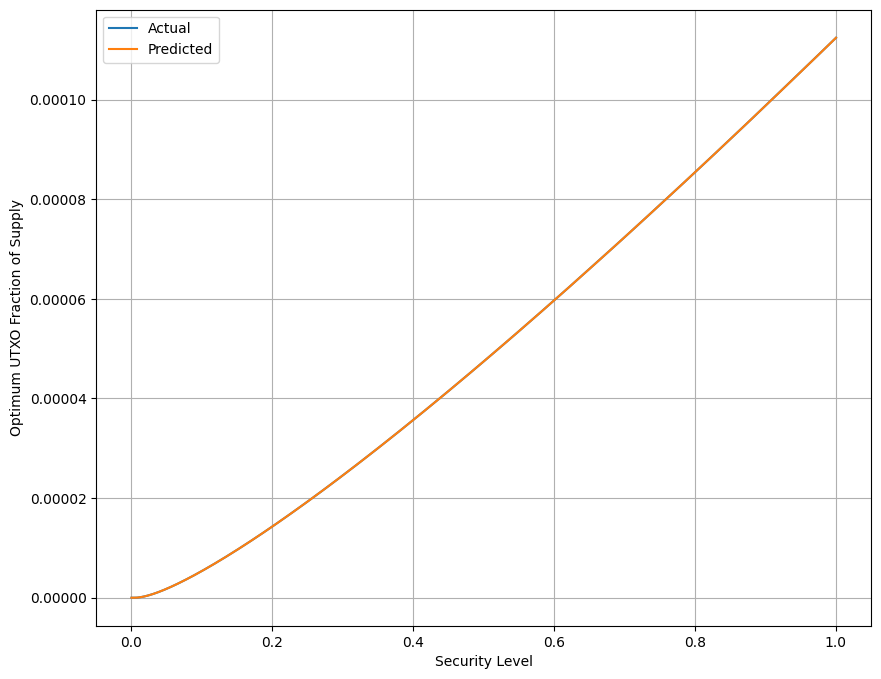

In [76]:
ypred = model.predict(exog)
fig, ax = plt.subplots(figsize=(10, 8))
h1, = ax.plot(secData, endog, label="Actual")
h2, = ax.plot(secData, ypred, label="Predicted")
ax.legend(handles=[h1, h2])
ax.set_xlabel("Security Level")
ax.set_ylabel("Optimum UTXO Fraction of Supply")
plt.grid(which="both")
plt.show()

In [77]:
def testSecurityForDiff(diff, supply):
    
    preciseStatic = getPreciseStaticFromSupply(supply)
    size, reward = findPeak(diff, preciseStatic, iterations=50)
    print(f"Expect {size:.6f}ppc for {reward:.4f}% reward")

    exog = getSecurityExog(np.array([getSecurityLevel(diff, supply)]))
    predictedSize = model.predict(exog)[0]*supply
    predictedReward = averageReward(predictedSize, diff, preciseStatic)
    print(f"Predicted {predictedSize:.6f}ppc for {predictedReward:.4f}% reward")

In [78]:
testSecurityForDiff(DIFF, SUPPLY)

Expect 127.447054ppc for 4.7309% reward
Predicted 127.415320ppc for 4.7309% reward


In [79]:
# What if difficulty is 10x higher?
testSecurityForDiff(DIFF*10, SUPPLY)

Expect 2769.445608ppc for 3.1336% reward
Predicted 2769.475376ppc for 3.1336% reward


In [80]:
# What if difficulty is 5x lower?
testSecurityForDiff(DIFF/5, SUPPLY)

Expect 6.567126ppc for 13.9356% reward
Predicted 6.401103ppc for 13.9353% reward


In [81]:
# What if supply is 10x higher?
testSecurityForDiff(DIFF, SUPPLY*10)

Expect 6.671011ppc for 26.9047% reward
Predicted 7.997701ppc for 26.9033% reward


## Multi-output Simulation

Since the geometric simulation looks at a single output in isolation, a wallet containing many smaller outputs may produce a different outcome.

In [82]:
import random, math

In [83]:
def randomDaysToMint(size):

    adj = size / DIFF
    daysToMint=MIN_PROB_DAYS+0.5
    dayProbs = 1 - (1 - probSecs[:RAMP_UP+1]*adj)**SECDAY

    for x in range(RAMP_UP):
        if random.random()<dayProbs[x]:
            return daysToMint
        daysToMint+=1

    days = daysToMint+np.random.geometric(dayProbs[-1])
    return days if days < NO_MINT_DAY else NO_MINT_DAY

def calcReward(size, daysToMint):
    return 0 if daysToMint == NO_MINT_DAY else size*RELATIVE_REWARD*min(365, daysToMint)/DAYYEAR + STATIC_REWARD

def multiSim(size, n, sims=50000):

    # Split if over size*2^0.5
    maxSize = size*2**0.5
    
    startBalance = size*n
    simDay = 0

    mintDayIndices = np.random.choice(MAX_DAYS+1, size=n, p=generateDailyProbs(size, DIFF))
    nextMintDays = np.take(DAYS_WITH_NO_MINT, mintDayIndices)
    nextMintRewards = np.take(dailyRewards(size, STATIC_REWARD), mintDayIndices)
    outBalances = np.full(n, size, dtype=float)

    for i in range(sims):
        
        simDay = nextMintDays.min()
        index = nextMintDays.argmin()

        newBalance = outBalances[index] + nextMintRewards[index]

        # Split?
        if newBalance > maxSize:
            newBalance /= 2

            # Add new split utxo
            daysToMint = randomDaysToMint(newBalance)
            reward = calcReward(newBalance, daysToMint)
            nextMintDays = np.append(nextMintDays, simDay + daysToMint)
            nextMintRewards = np.append(nextMintRewards, reward)
            outBalances = np.append(outBalances, newBalance)

        # Update current utxo
        daysToMint = randomDaysToMint(newBalance)
        reward = calcReward(newBalance, daysToMint)
        nextMintDays[index] = simDay + daysToMint
        nextMintRewards[index] = reward
        outBalances[index] = newBalance;            
            
    endBalance = outBalances.sum()
    return ((endBalance/startBalance)**(DAYYEAR/nextMintDays.min())-1)*100

In [84]:
def simAndPrint(size, n):
    size = math.floor(size*1000000)/1000000
    print(f"{size}*{n}")
    return multiSim(size, n)

In [85]:
simSizes = [10**(x/10) for x in range(41)]
simulatedReward = np.fromiter((simAndPrint(x, int(10000//x)) for x in simSizes), dtype=float)

1.0*10000
1.258925*7943
1.584893*6309
1.995262*5011
2.511886*3981
3.162277*3162
3.981071*2511
5.011872*1995
6.309573*1584
7.943282*1258
10.0*1000
12.589254*794
15.848931*630
19.952623*501
25.118864*398
31.622776*316
39.810717*251
50.118723*199
63.095734*158
79.432823*125
100.0*100
125.892541*79
158.489319*63
199.526231*50
251.188643*39
316.227766*31
398.10717*25
501.187233*19
630.957344*15
794.328234*12
1000.0*10
1258.925411*7
1584.893192*6
1995.262314*5
2511.886431*3
3162.27766*3
3981.071705*2
5011.872336*1
6309.573444*1
7943.282347*1
10000.0*1


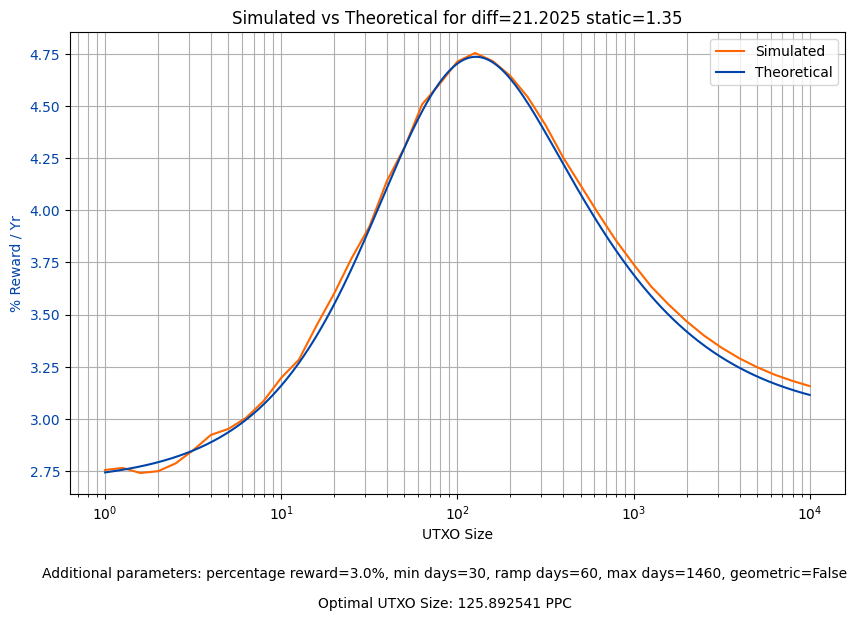

In [86]:
fig, rewardAx = plt.subplots(figsize=(10, 6))
rewardAx.set_title(f"Simulated vs Theoretical for diff={DIFF} static={STATIC_REWARD}")
rewardAx.set_xlabel("UTXO Size")
rewardAx.tick_params(axis ='y', labelcolor=colour) 
rewardAx.set_ylabel("% Reward / Yr", color=colour)

p1, = rewardAx.plot(simSizes, simulatedReward, color="#F60", label="Simulated")
p2, = rewardAx.plot(sizes, rewardForSizes, color="#04A", label="Theoretical")
rewardAx.legend(handles=[p1, p2])

addFigText(simSizes[simulatedReward.argmax()])

plt.xscale("log")
rewardAx.grid(which="both")
plt.show()